/home/amai/delaunay_splatting
Vertex Torch Grad: [[-0.01596531 -0.07518616  0.06396992]
 [ 0.01071359 -0.02270043 -0.09679829]
 [ 0.00030297  0.04238345  0.09057346]
 [-0.01162447 -0.03450172 -0.09313702]]
Vertex Jax Grad: [[-4.3374124 -9.8602085  3.2245057]
 [ 1.7349645  3.9440825 -1.289802 ]
 [ 1.7349645  3.9440825 -1.289802 ]
 [ 1.7349645  3.9440825 -1.289802 ]]
Max value torch: 0.4095863401889801
Max value jax: 0.4097067713737488
Mean Error: 1.0043692782346625e-05
Max Error: 0.0023626089096069336
Torch dist loss: 0.0005508310277946293
Jax dist loss: 0.0005511703202500939
3.392924554646015e-07


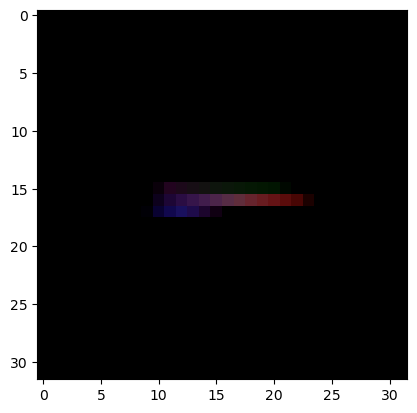

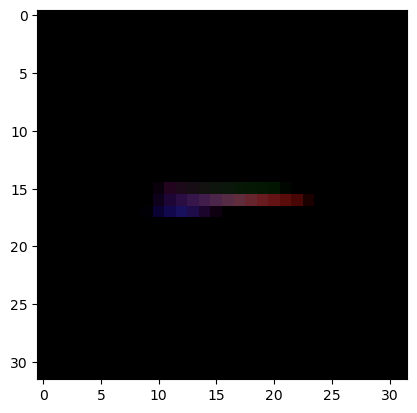

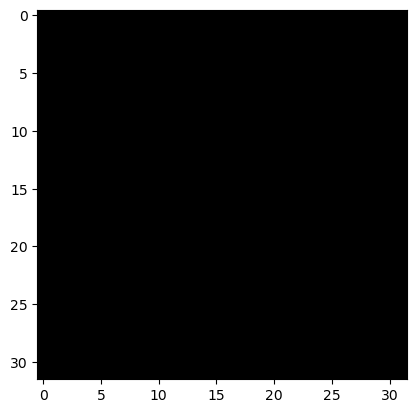

In [4]:
import os
VERSION = 11
if VERSION is not None:
    os.environ["CC"] = f"/usr/bin/gcc-{VERSION}"
    os.environ["CXX"] = f"/usr/bin/g++-{VERSION}"
from pathlib import Path
import sys
sys.path.insert(0, str(Path(os.path.abspath('')).parent))
print(str(Path(os.path.abspath('')).parent))

from utils.compare_quad import test_tetrahedra_rendering, setup_camera
from delaunay_rasterization.internal.tile_shader_slang import point2image
import torch
import matplotlib.pyplot as plt
import numpy as np
import random

# Create sample tetrahedra
torch.manual_seed(0)
N = 4
vertices = (torch.rand((N, 3)).cuda() * 2 - 1) * 100
indices = torch.tensor([[0, 1, 2, 3]]).int().cuda()

vertex_color = torch.tensor([
        [1.0, 0.0, 0.0],
        [0.0, 1.0, 0.0],
        [0.0, 0.0, 1.0],
        [0.5, 0.0, 0.5],
]).cuda()
tet_density = torch.tensor([[10.0]]).cuda()
vertex_color = torch.cat([tet_density.reshape(1, 1), vertex_color.reshape(1, -1)], dim=1)


# Generate random barycentric coordinates that sum to 1
barycentric = torch.rand(4).cuda()
barycentric = barycentric / barycentric.sum()

# Use barycentric coordinates to get a point inside the tetrahedron
origin = vertices[indices[0]].T @ barycentric  # Shape: (3,)

# Update viewmat with new origin
viewmat = torch.eye(4)
viewmat[:3, 3] = origin  # Set translation to sampled point
viewmat = torch.linalg.inv(viewmat)
vertices = torch.tensor([[-0.0954798982, -0.0576470010,  0.0907066390],
        [-0.0794274211, -0.0494611152,  0.0444854014],
        [-0.0524959937,  0.0647660419,  0.0939735770],
        [-0.0065456270,  0.0679433569,  0.0750745535]], device='cuda:0')
viewmat = torch.tensor([[-0.8002946973, -0.5985016227,  0.0363887995, -0.0098749101],
        [-0.4739684165,  0.6686108708,  0.5729864836, -0.0947880447],
        [ 0.3672632575, -0.4413108826,  0.8187565804,  0.6489951611],
        [ 0.0000000000,  0.0000000000,  0.0000000000,  1.0000000000]],
       device='cuda:0')
vertices = torch.tensor([[ 0.2430675477, -0.3873929977,  0.3781652451],
        [ 0.2899414003, -0.1144087315,  0.2279857695],
        [-0.3941484988,  0.2187604010,  0.3265861571],
        [-0.3360970914,  0.1398774236,  0.1634573936]], device='cuda:0')
viewmat = torch.tensor([[ 9.2208576202e-01, -3.7686905265e-01,  8.7907373905e-02,
          8.3750230260e-05],
        [ 3.0987361446e-02,  2.9833433032e-01,  9.5395827293e-01,
         -2.2361640632e-01],
        [ 3.8574317098e-01,  8.7690722942e-01, -2.8676798940e-01,
          1.9718817472e+00],
        [ 2.1461694644e-09, -2.4329395387e-08, -3.2908822334e-09,
          1.0000000000e+00]], device='cuda:0')
# vertices = torch.tensor([[-0.3819195926, -0.2305880040,  0.3628265560],
#         [-0.3177096844, -0.1978444606,  0.1779416054],
#         [-0.2099839747,  0.2590641677,  0.3758943081],
#         [-0.0261825081,  0.2717734277,  0.3002982140]], device='cuda:0')
# viewmat = torch.tensor([[ 8.0029475689e-01,  5.9850162268e-01, -3.6388747394e-02,
#           3.9499610662e-02],
#         [-4.7396835685e-01,  6.6861087084e-01,  5.7298648357e-01,
#          -3.7915235758e-01],
#         [-3.6726331711e-01,  4.4131094217e-01, -8.1875652075e-01,
#           1.0243387222e+00],
#         [-1.3238860674e-08, -6.2472373941e-09,  2.1942579309e-08,
#           1.0000000000e+00]], device='cuda:0')
# vertices = torch.tensor([[ 0.2430675477, -0.3873929977,  0.3781652451],
#         [ 0.2899414003, -0.1144087315,  0.2279857695],
#         [-0.3941484988,  0.2187604010,  0.3265861571],
#         [-0.3360970914,  0.1398774236,  0.1634573936]], device='cuda:0')
# viewmat = torch.tensor([[ 9.2208570242e-01, -3.7686908245e-01,  8.7907396257e-02,
#           8.3774328232e-05],
#         [ 3.0987352133e-02,  2.9833433032e-01,  9.5395833254e-01,
#          -2.2361648083e-01],
#         [ 3.8574314117e-01,  8.7690728903e-01, -2.8676798940e-01,
#           7.0029509068e-01],
#         [ 0.0000000000e+00,  0.0000000000e+00,  0.0000000000e+00,
#           1.0000000000e+00]], device='cuda:0')
# vertices = torch.tensor([[ 0.2430675477, -0.3873929977,  0.3781652451],
#         [ 0.2899414003, -0.1144087315,  0.2279857695],
#         [-0.3941484988,  0.2187604010,  0.3265861571],
#         [-0.3360970914,  0.1398774236,  0.1634573936]], device='cuda:0')
# viewmat = torch.tensor([[-0.4876191318, -0.8475935459, -0.2093149424, -0.0044252351],
#         [-0.8258575201,  0.5255668759, -0.2043008804,  0.1754622161],
#         [ 0.2831731141,  0.0732432902, -0.9562679529,  0.2541924715],
#         [ 0.0000000000,  0.0000000000,  0.0000000000,  1.0000000000]],
#        device='cuda:0')
# vertices = torch.tensor([[ 0.2430675477, -0.3873929977,  0.3781652451],
#         [ 0.2899414003, -0.1144087315,  0.2279857695],
#         [-0.3941484988,  0.2187604010,  0.3265861571],
#         [-0.3360970914,  0.1398774236,  0.1634573936]], device='cuda:0')
# viewmat = torch.tensor([[-0.7677200437,  0.1756590605,  0.6162384152, -0.0968539640],
#         [ 0.3055213988,  0.9456868172,  0.1110551804,  0.0558680296],
#         [-0.5632607341,  0.2735333145, -0.7796902657,  0.2879556417],
#         [ 0.0000000000,  0.0000000000,  0.0000000000,  1.0000000000]],
#        device='cuda:0')

# Run test
fov = 90
results = test_tetrahedra_rendering(
    vertices.cuda(), indices, vertex_color, tet_density, viewmat,
    height=32, width=32, tile_size=8, fov=fov, tmin=0)
#     height=32, width=32, tile_size=8, fov=140, tmin=0)
    # height=8, width=8)
viewmat, projection_matrix, cam_pos, fovy, fovx, fx, fy = setup_camera(32, 32, fov, viewmat)
image_points = point2image(vertices.cuda(), viewmat.cuda(), projection_matrix.cuda(), cam_pos.cuda()).cpu().numpy()

# plt.scatter(image_points[:, 0], image_points[:, 1], c=vertex_color.cpu().numpy())

# print(f"Num gt: {(results['torch_image'] > 0).sum()//3} vs Pred: {results['tet_area']}")
# print(results['rect_tile_space'])
print(f"Vertex Torch Grad: {results['torch_vertex_grad']}")
print(f"Vertex Jax Grad: {results['jax_vertex_grad']}")
# print(f"RGBS Torch Grad: {results['torch_rgbs_grad']}")
# print(f"RGBS Jax Grad: {results['jax_rgbs_grad']}")
print(f"Max value torch: {results['torch_image'].max()}")
print(f"Max value jax: {results['jax_image'].max()}")
print(f"Mean Error: {results['mean_error']}")
print(f"Max Error: {results['max_error']}")
print(f"Torch dist loss: {results['torch_dist_loss']}")
print(f"Jax dist loss: {results['jax_dist_loss']}")
# print(results['torch_extras']['viewspace_points'])
print(f"{results['dist_loss_err']}")
# jdist_img = results['jax_dist_img']
# plt.imshow(jdist_img)
# plt.show()
# dist_img = results['torch_dist_img']
# total_density = (dist_img[:, :, 2]**2).clip(min=1e-6)
# print(total_density.max(), dist_img.reshape(-1, dist_img.shape[-1]).max(axis=0))
# dist_img = (((dist_img[:, :, 0] - dist_img[:, :, 1]) + dist_img[:, :, 4]) / total_density).clip(min=0)
# plt.imshow(dist_img)
# plt.show()
# plt.imshow(dist_img - jdist_img)
# plt.show()
# print(dist_img.max(), jdist_img.max())
plt.imshow(results['torch_image'])
plt.show()
plt.imshow(results['jax_image'][..., :3])
plt.show()
plt.imshow(np.abs(results['jax_image'][..., :3] - results['torch_image']))
plt.show()

In [2]:
from jaxutil.tetra_quad import lossfun_distortion

def safe_exp(x):
    return np.exp(np.clip(x, a_min=None, a_max=20))

def moment_0_int(a, b, s1):
    return (1 - np.exp(s1*(a - b)))/s1
def moment_1_int(a, b, s1):
    return (a*s1 - (b*s1 + 1)*np.exp(s1*(a - b)) + 1)/s1**2

def self_dist(a, b, s):
    ds = s * (a-b)
    return (2 * s * (a-b) * np.exp(ds) + 1 - np.exp(2*ds)) / s**3

def update_distortion_state_int(state, t1, t2, sigma):
    x, y, z, w, v, T = state
    m0 = T*moment_0_int(t1, t2, sigma)
    m1 = T*moment_1_int(t1, t2, sigma)
    new_z = z + m0
    new_w = w + m1
    new_x = x + z * m1
    new_y = y + w * m0
    new_v = v + T*T*self_dist(t1, t2, sigma)
    alpha = 1-np.exp(-sigma*(t2-t1))
    new_T = T * (1-alpha)
    return np.array([new_x, new_y, new_z, new_w, new_v, new_T])

def incremental_distortion(t, sigma):
    state = np.zeros(6, dtype=np.float32)
    state[-1] = 1
    for i in range(len(sigma)):
        state = update_distortion_state_int(state, t[i], t[i+1], sigma[i])
    x, y, _, _, v, _ = state
    return 2*(x - y) + v 

i, j = 20, 25
weights = results['extras']['weights'][i, j, 0]
tdist = results['extras']['tdist'][i, j]
y = results['jax_dist_img'][i, j]
print("Jon Barron dist:", lossfun_distortion(tdist, weights))
# calculate interval length
xs, = np.where(weights > 1e-5)
start = tdist[np.min(xs)]
end = tdist[np.max(xs)]

old_state = np.zeros(6)
old_state[-1] = 1
# print(update_distortion_state(old_state, 1, (start+end)*0.5, end-start))
# print("our distortion: ", update_distortion_state_int(old_state, start, end, 1))
print("our distortion:", incremental_distortion(np.array([start, end]), np.array([1])))
# print(update_distortion_state(old_state, 0, 10, 0))
# print(incremental_distortion(tdist, weights))
plt.plot(tdist[:-1], weights, c='black')
plt.show()
print("Exact integral:", self_dist(start, end, 1))

# x = np.linspace(0, 10, 100)
# plt.plot(x, self_dist(start, end, x))
# plt.show()
# x = np.linspace(0, end-start, 100)
# plt.plot(x, self_dist(start, start+x, 1))
# plt.show()
# x = np.linspace(0, start, 100)
# plt.plot(x, self_dist(x, x-start+end, 1))
# plt.show()

Jon Barron dist: 0.0


ValueError: zero-size array to reduction operation minimum which has no identity

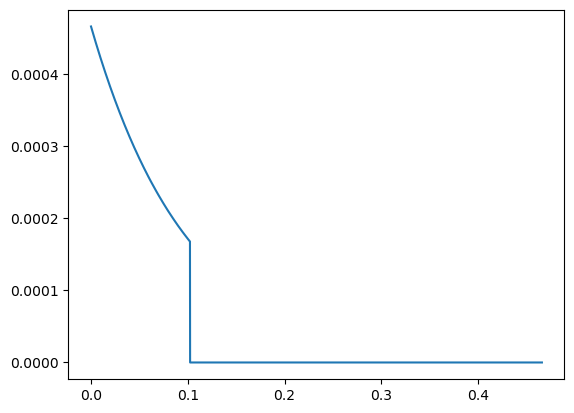

[4.6574372e-05 9.3148745e-05 1.3972311e-04 ... 4.6560398e-01 4.6565056e-01
 4.6569714e-01]


In [ ]:

i, j = 30, 5
plt.plot(results['extras']['tdist'][i, j][1:], results['extras']['weights'][i, j][0])
plt.show()
print(results['extras']['tdist'][i, j][1:])